## TIMESTACK PER LE SDS

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:

# Importiamo le mie funzioni
import sys
sys.path.append('/Users/paolasouto/Desktop/DOTTORATO/python/Functions')
from My_functions import SDS_Errors 

# Importamos 
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
#mport fiona
import geopandas as gp
import scipy

<font color=blue>**Importiamo le SDS ottenute con CoastSat per San Michele Sassi Neri**<font>

In [14]:
sitename = 'Sirolo'
dir_SDS = '/Users/paolasouto/Desktop/DOTTORATO/python/CoastSat'
file_CoastSat_SH = sitename + '_output.geojson'

In [15]:
CoastSat_SDS = SDS_Errors.Read_CoastSat_SDS(dir_SDS,sitename)

In [16]:
len(CoastSat_SDS)

53

<font color=blue>**Pulizia dei dati di CoastSat**<font>

In [6]:
## Facciamo la prova usando Minimum spanning tree algorithm (MST) used in graph theory
##  modify to perform over geographic data

 <font color=blue>1) Fare una filtro per togliere i punti che sono al di fuori del path più lungo, chiamamoli outputs<font>

In [17]:
def minimum_spanning_tree(X, copy_X=True):
    """X are edge weights of fully connected graph"""
    if copy_X:
        X = X.copy()

    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    n_vertices = X.shape[0]
    spanning_edges = []

    # initialize with node 0:                                                                                        
    visited_vertices = [0]                                                                                           
    num_visited = 1
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf

    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices                                                     
        new_edge = divmod(new_edge, n_vertices)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                      
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                    
        num_visited += 1
    return np.vstack(spanning_edges)

In [27]:
def define_breaking_points(edge_list, P):
        
    o=0
    index_break = []
    for i in range(0,len(edge_list)-1):
        o+=1
        if edge_list[i][1] == edge_list[i+1][0]:
            continue
        else:
            index_break.append(o)

    # Insertiamo la posizione 0
    index_break.insert(0,0)

    # Insertiamo la posizione finale
    index_break.append(len(edge_list))

    # Troviamo gli indici del path piu lungo

    ini = index_break[int(np.where(np.diff(index_break) == np.diff(index_break).max())[0])]
    fin = index_break[int(np.where(np.diff(index_break) == np.diff(index_break).max())[0])+1]


    edge_list2 = edge_list[ini:fin] 


    edges = []
    for edge in edge_list2:
        i, j = edge
        #plt.plot([P[i, 0], P[j, 0]], [P[i, 1], P[j, 1]], 'r.')
        edges.append([(P[i, 0], P[j, 0]), (P[i, 1], P[j, 1])])
        #edges.append([(P[i, 0], P[j, 0]), (P[i, 1], P[j, 1])])
    #plt.show()
    
    ## Definiamo il df
    
    x = []
    y = []

    for coor in edges:
        x.append(coor[0][0])
        x.append(coor[0][1])
        y.append(coor[1][0])
        y.append(coor[1][1])

    df = pd.DataFrame({'cross':x, 'along':y})


    return df

In [30]:
def Geographical_MST(idx):
    
    "This fucking thing it's still not stable, but show must go one (it works in this case)"
    
    P = np.array(CoastSat_SDS['geometry'][idx].coords)
    
    X = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(P, metric='euclidean'))

    edge_list = minimum_spanning_tree(X)
    
    df = define_breaking_points(edge_list, P)
    
    return df
    


In [33]:
df_mst = Geographical_MST(24)
df = pd.DataFrame(CoastSat_SDS['geometry'][24].coords, columns=['cross', 'along'])

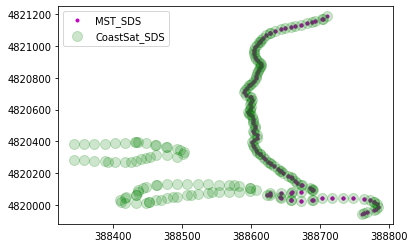

In [34]:

plt.plot(df_mst['cross'], df_mst['along'], 'mo', markersize=3)


plt.plot(df['cross'], df['along'], 'go', alpha=0.2, markersize=10)




plt.legend(['MST_SDS', 'CoastSat_SDS'])

<font color=green>Identification of the shoreline positions which have outliers<font>

In [606]:
index_outliers = [1,2,21,22,24]

<font color=green>Definiamo gli stessi limiti geografici che per quelle digitalizate a mano dalle fotocamere di Sirolo<font>

In [607]:
max_lonf = 4821136.679137562
min_lonf = 4821017.278573326
max_loni = 4820139.203408777
min_loni = 4820089.736224545

<font color=green>Definiamo la benchmark<font>

In [608]:
bench = np.linspace(min_loni-50, max_lonf+50, 150) #
x_bench = [388604.374069 - 80]*len(bench)

<font color=green>Interpolazione della benchmarck<font>

In [664]:
xd = np.diff(x_bench)
yd = np.diff(bench)
dist = np.sqrt(xd**2+yd**2)
u = np.cumsum(dist)
u = np.hstack([[0],u])

t = np.linspace(0,u.max(),1500) # Con 20 ptos evaluamos cada 60 m, con 30 c 40 m
xn = np.interp(t, u, x_bench)
yn = np.interp(t, u, bench)

<font color=green>Calcoliamo le distanze a la benchmark di ogni shoreline<font>

Numero de lineas procesadas:  48


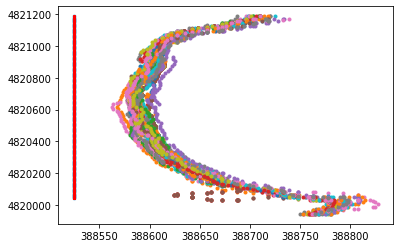

In [973]:
UNDEF = np.nan # Definiamo il valore da mettere a destra e sinistra qundo nella sh non c'è il pto
matcr = pd.DataFrame() # si inizializa il pandasDataFrame
o = 0
vec_fecha = []

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x_bench,bench,'o', alpha=0.5, markersize=3)
ax.plot(xn,yn,'ro', markersize=2)

for i in range(len(CoastSat_SDS)): #
    o +=1
    vec_fecha.append(pd.to_datetime(CoastSat_SDS['date'][i], utc = True).date())
    
    if i in index_outliers: #
        sh = Geographical_MST(i)
    else:
        sh = pd.DataFrame(CoastSat_SDS['geometry'][i].coords, columns=['cross','along'])
    
    sh.sort_values(by=['along'], inplace = True, ascending = True)
    Xinterp = np.interp(yn, sh['along'], sh['cross'], left=UNDEF, right=UNDEF) # 3) Interpo  
    dist_x = pd.DataFrame(Xinterp-xn) # 4) Calcolo delle distanze alla benchmark
    matcr = pd.concat([matcr, dist_x], axis=1) # 5) Generiamo il pandasDataFrame

    numbers = list(range(len(matcr.columns)))
    matcr.columns = numbers
        
    plt.plot(sh['cross'], sh['along'],'.')
    
print('Numero de lineas procesadas: ', o)     

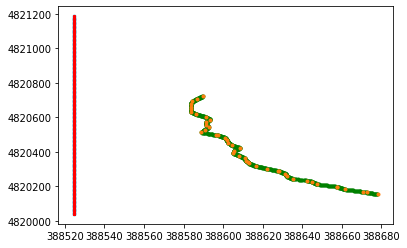

In [690]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x_bench,bench,'o', alpha=0.5, markersize=3)
ax.plot(xn,yn,'ro', markersize=2)
ax.plot(Xinterp,yn, 'g.')
ax.plot(sh['cross'], sh['along'],'.')


In [ ]:
CoastSat_SDS

<font color=green>**Calcoliamo Yx(t) = la posizione media crosshore delle SH que si posiedono**<font>

In [691]:
crossme = matcr.mean(axis=1)
crossme = pd.DataFrame(crossme)

<font color=green>**Calcoliamo Dx(t,x), che è la matrice Deviazione**<font>

In [692]:
matD = pd.DataFrame()
for j in range(len(matcr.columns)):
    desv = pd.DataFrame(matcr.iloc[:,j] - crossme.T)
    matD = pd.concat([matD, desv], axis=0)
matD.reset_index(drop=True, inplace=True)

In [693]:
matD.isna().all().all()

False

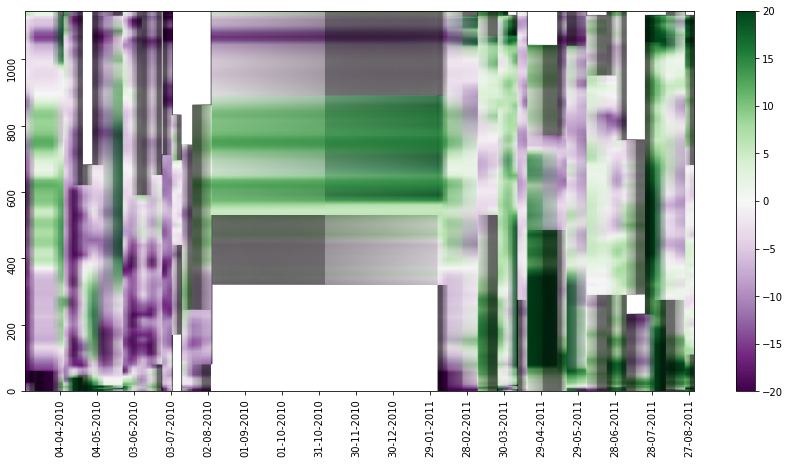

In [702]:
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr
from matplotlib.patches import Rectangle

## La stessa dimensione per pcolor
xx=np.arange(0,len(CoastSat_SDS))
yy=np.arange(0, len(yn))
vec_dist = np.linspace(0,(max_lonf+50)-(min_loni-50), len(yn)).astype(int)

## Definiamo gli x e gli y label

xx2 = xx[::4] # Take data each 4nth position
vec_fecha2 = vec_fecha[::4]
yy2 = yy[::10]
vec_dist2 = vec_dist[::10]



fig = plt.figure(figsize=(15,7))
ax = plt.gca()

cax = plt.pcolormesh(vec_fecha, vec_dist,matD.T, cmap='PRGn',shading='gouraud') #


ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
#ax.xaxis.set_minor_locator(mdates.DayLocator(interval=100))
#ax.tick_params(which='minor', length=4, color='r', labelcolor='r', rotation =90) # 
ax.tick_params(which='major', length=4, color='k', labelcolor='k', rotation =90) # 


plt.colorbar()
plt.clim([-20,20])

<font color=green>**Probiamo a fare l'interpolazione temporale**<font>

In [729]:
# calcoliamo il numero di timedeltas
timedeltas = []
for i in range(len(vec_fecha)-1):
    timedeltas.append(vec_fecha[i+1]-vec_fecha[i])

In [792]:
ff = np.cumsum(timedeltas)

In [796]:
ff[0].days

8

In [864]:
list_datesNum = []
for i in range(len(ff)):
    list_datesNum.append(ff[i].days)

In [865]:
list_datesNum.insert(0,1)

In [797]:
# generiamo un vetore crescente con il numero di elementi di vec_fecha
list_datesNum = np.arange(0,len(vec_fecha))

In [774]:
matD_zeros = matD.copy()
matD_zeros[ np.isnan(matD) ] = 0

In [814]:
matcr_zeros = matcr.copy()
matcr_zeros[ np.isnan(matcr) ] = 0

In [867]:
# Genrate the function which will allows as to interpolate

displacements_function = scipy.interpolate.interp2d(yn,list_datesNum,matcr_zeros.T)

In [ ]:
for 
pd.DataFrame(displacements_function(yn,1))


In [890]:
displacements_function(yn,1)

array([235.06690439, 233.80278205, 232.53865971, ..., 189.03232885,
       189.30425894, 189.57618903])

In [959]:
xxx = displacements_function(yn,24)
xxx21 = displacements_function(yn,21)

[]

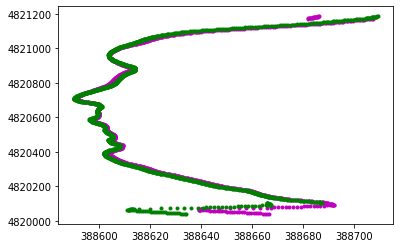

In [960]:
#dd = pd.DataFrame(CoastSat_SDS['geometry'][2].coords, columns=['cross', 'along'])
#dd3 = pd.DataFrame(CoastSat_SDS['geometry'][3].coords, columns=['cross', 'along'])

plt.plot(xn + xxx,yn, '.m')
plt.plot(xn + xxx21,yn, 'g.')
#plt.plot(dd['cross'], dd['along'], '.')
#plt.plot(dd3['cross'], dd3['along'], '.')


plt.plot()

In [1009]:
## Lo hacemos sin quitar el gap de 150 dias
## Sin quitar tampoco el ruido de las shorelines (outliers)

matcr_interpolate_days = pd.DataFrame()
big_gaps = []
for i in range(0,len(list_datesNum)-1,1):
    search = np.arange(list_datesNum[i], list_datesNum[i+1])
    for sear in search:
        if sear in list_datesNum:
            sh = Geographical_MST(int(list_datesNum.index(sear)))
        else:
            xxx = displacements_function(yn,sear)
            long = xxx + xn
            sh = pd.DataFrame({'cross':long, 'along':yn})

        sh.sort_values(by=['along'], inplace = True, ascending = True)
        Xinterp = np.interp(yn, sh['along'], sh['cross'], left=UNDEF, right=UNDEF) # 3) Interpo  
        dist_x = pd.DataFrame(Xinterp-xn) # 4) Calcolo delle distanze alla benchmark
        matcr_interpolate_days = pd.concat([matcr_interpolate_days, dist_x], axis=1) # 5) Generiamo il pandasDataFrame

    numbers = list(range(len(matcr_interpolate_days.columns)))
    matcr_interpolate_days.columns = numbers

    

In [1010]:
crossme_interpDays = matcr_interpolate_days.mean(axis=1)
crossme_interpDays = pd.DataFrame(crossme_interpDays)

In [ ]:
matD_interpDays = pd.DataFrame()
for j in range(len(matcr_interpolate_days.columns)):
    print(j)
    desv_interpDays = pd.DataFrame(matcr_interpolate_days.iloc[:,j] - crossme_interpDays.T)
    matD_interpDays = pd.concat([matD_interpDays, desv_interpDays], axis=0)
matD_interpDays.reset_index(drop=True, inplace=True)

In [1017]:
##542

544

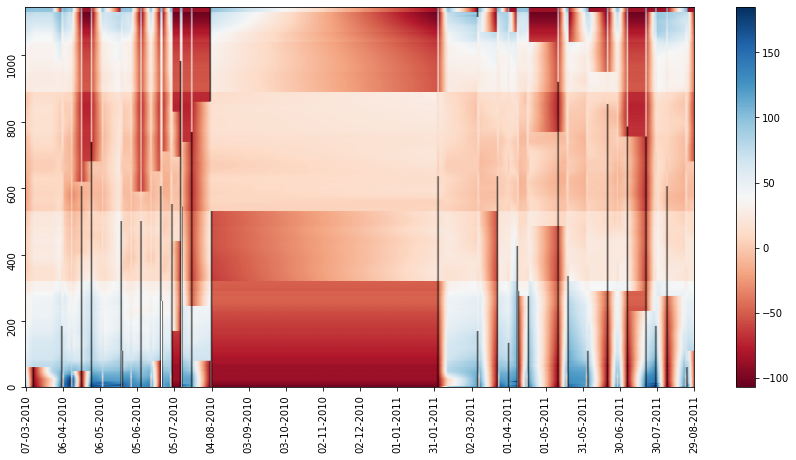

In [1076]:
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr
from matplotlib.patches import Rectangle
from dateutil.rrule import rrule, DAILY



## La stessa dimensione per pcolor

vec_fechaInter = list(rrule(DAILY, dtstart=vec_fecha[0], until=vec_fecha[-1]))
vec_fechaInter = vec_fechaInter[0:542]


fig = plt.figure(figsize=(15,7))
ax = plt.gca()

cax = plt.pcolormesh(vec_fechaInter, vec_dist,matD_interpDays.T, cmap='RdBu',shading='gouraud') #


ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
#ax.xaxis.set_minor_locator(mdates.DayLocator(interval=100))
#ax.tick_params(which='minor', length=4, color='r', labelcolor='r', rotation =90) # 
ax.tick_params(which='major', length=4, color='k', labelcolor='k', rotation =90) # 


plt.colorbar()
#plt.clim([-20,20])

<font color=blue>2) Secondo filtro per togliere tutti quelli punti minori a una determinata longitudine<font>

<font color=blue>Smooth delle shoreline<font>

In [ ]:
from scipy.signal import savgol_filter
Yhat = savgol_filter(np.array(df['along']),21, 3)

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
plt.plot(df['cross'], Yhat, '.')

<font color=blue>2) Fare la interpolazione sulle linea di riva di L7 in qui il satellite non funzionava è ha mancanze di dati in forma di bande, in modo tale di avere una linea di riva completa<font>
    
<font color=red>**Ancora no**<font>

In [ ]:
dd = pd.DataFrame({'x':x, 'y':y})
dd.sort_values(by='x', ascending=True, axis=0, inplace=True)
dd.drop_duplicates(subset = 'x', keep ='first', inplace=True)
dd.reset_index(drop=True, inplace=True)
points = np.array(dd)
len(points)

In [ ]:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

In [ ]:
from scipy.interpolate import interp1d
# Interpolation for different methods:
interpolations_methods = ['slinear', 'quadratic', 'cubic']
alpha = np.linspace(0, 1, 75)

interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
plt.figure(figsize=(7,7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '.-', label=method_name);

plt.plot(*points.T, 'ok', label='original points');
plt.legend(); plt.xlabel('x'); plt.ylabel('y');

<font color=blue>**Generare la matrice di spostamenti per le date di qui disponiamo**<font>

<font color=blue>**Inteporlare temporalmente in modo di avere una SDS per giorno**<font>

<font color=blue>**Generare un'altra volta la matrice spostamenti aggiungendo le nuove date**<font>

In [ ]:
df = pd.DataFrame(CoastSat_SDS['geometry'][20].coords, columns=['x', 'y'])

In [ ]:
plt.plot(df['x'], df['y'], 'r.')

In [ ]:
CoastSat_SDS['geometry'][20]

In [ ]:
CoastSat_SDS